In [15]:
%%capture
pip install -r requirements.txt


Daily ledger for 2024-08-20 generated with 7 transactions.
Daily ledger for 2024-08-21 generated with 6 transactions.
Daily ledger for 2024-08-22 generated with 7 transactions.
Daily ledger for 2024-08-23 generated with 5 transactions.
Daily ledger for 2024-08-24 generated with 6 transactions.
Daily ledger for 2024-08-25 generated with 8 transactions.
Daily ledger for 2024-08-26 generated with 6 transactions.
Daily ledger for 2024-08-27 generated with 7 transactions.
Daily ledger for 2024-08-28 generated with 6 transactions.
Daily ledger for 2024-08-29 generated with 7 transactions.
Daily ledger for 2024-08-30 generated with 5 transactions.
Daily ledger for 2024-08-31 generated with 6 transactions.
Daily ledger for 2024-09-01 generated with 5 transactions.
Daily ledger for 2024-09-02 generated with 7 transactions.
Daily ledger for 2024-09-03 generated with 5 transactions.
Daily ledger for 2024-09-04 generated with 7 transactions.
Daily ledger for 2024-09-05 generated with 5 transaction

,currency,total_balance
0,EUR,26446.7549
1,GBP,-2641.6033
2,USD,-5603.7023


,type,amount
0,deposit,11257.3400
1,fee,-130.4407
2,fx_transaction_in,15848.6006
3,fx_transaction_out,-15834.8300
4,loan_payment,-17914.0100
5,withdrawal,-19176.6100


Monthly financial statements generated.


{'Capital Adequacy Ratio (CAR)': '20.00%'}

Regulatory ratios calculated.


,transaction_id,date,client_id,type,amount,currency


,client_id,total_amount


Regulatory reports generated.


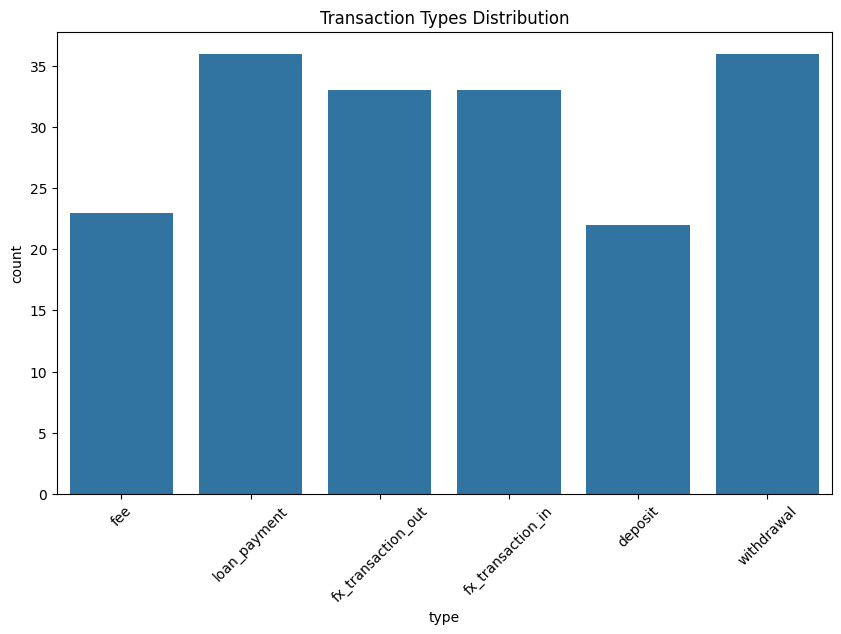

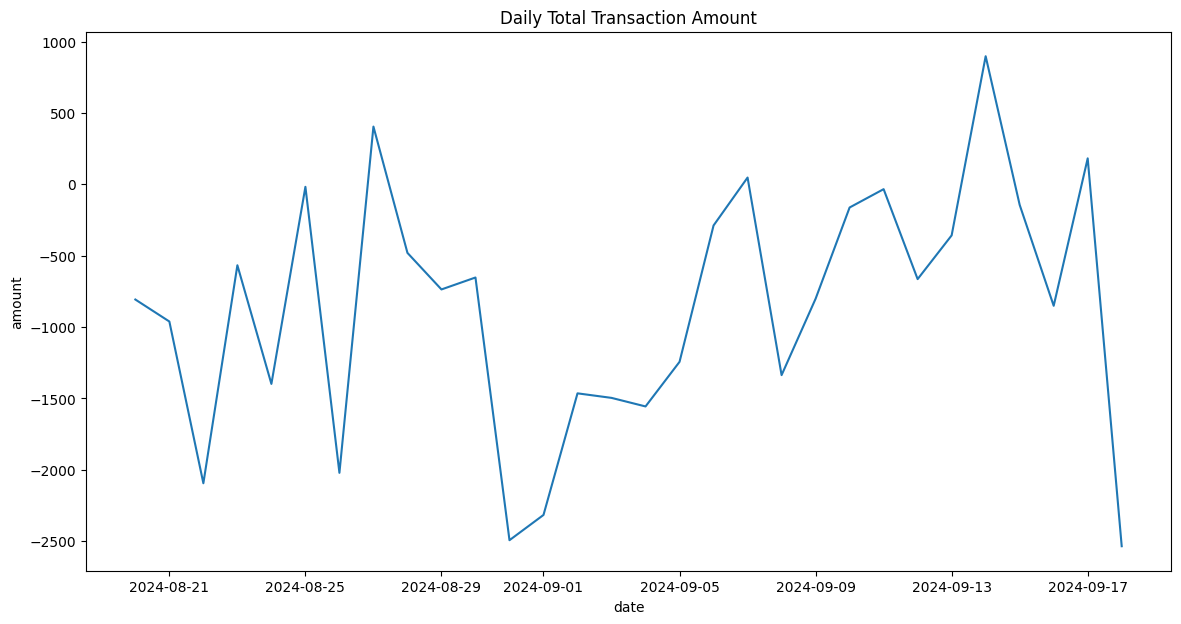

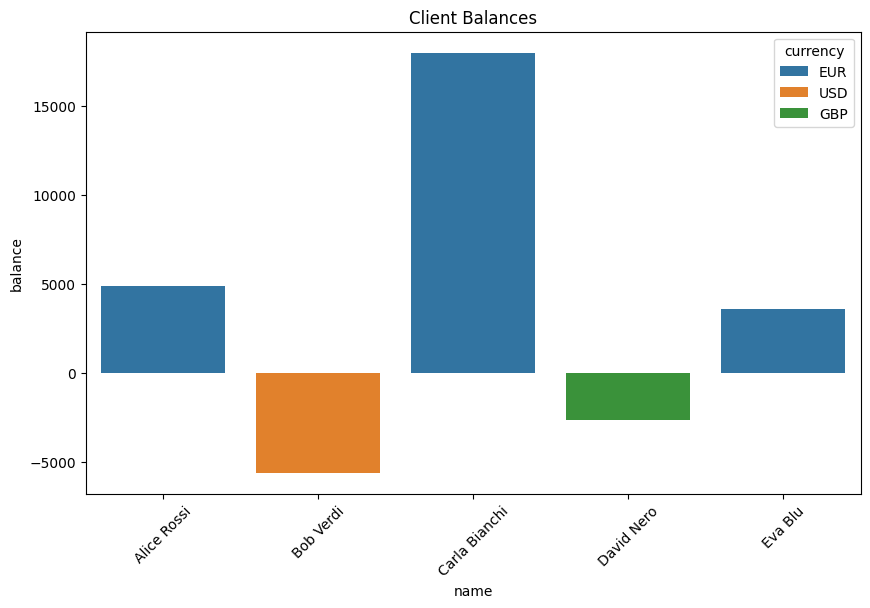

In [16]:
# Bank Simulation Notebook

# Import Necessary Modules
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Initialize Database and Tables
# Connect to SQLite database
conn = sqlite3.connect('bank_simulation.db')
cursor = conn.cursor()

# Create clients table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS clients (
        client_id INTEGER PRIMARY KEY,
        name TEXT,
        account_type TEXT,
        currency TEXT,
        balance REAL
    )
''')

# Create transactions table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS transactions (
        transaction_id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        client_id INTEGER,
        type TEXT,
        amount REAL,
        currency TEXT,
        FOREIGN KEY(client_id) REFERENCES clients(client_id)
    )
''')

conn.commit()

# Create Mock Clients
# Sample client data
clients = [
    (1, 'Alice Rossi', 'savings', 'EUR', 10000.00),
    (2, 'Bob Verdi', 'checking', 'USD', 5000.00),
    (3, 'Carla Bianchi', 'corporate', 'EUR', 25000.00),
    (4, 'David Nero', 'savings', 'GBP', 8000.00),
    (5, 'Eva Blu', 'checking', 'EUR', 12000.00),
    # Add more clients as needed
]

# Insert clients into the database
cursor.executemany('''
    INSERT OR REPLACE INTO clients (client_id, name, account_type, currency, balance)
    VALUES (?, ?, ?, ?, ?)
''', clients)

conn.commit()

# Define Transaction Functions
def deposit(client_id, amount, currency, date):
    cursor.execute('''
        UPDATE clients SET balance = balance + ?
        WHERE client_id = ? AND currency = ?
    ''', (amount, client_id, currency))
    record_transaction(client_id, 'deposit', amount, currency, date)

def withdraw(client_id, amount, currency, date):
    cursor.execute('''
        UPDATE clients SET balance = balance - ?
        WHERE client_id = ? AND currency = ?
    ''', (amount, client_id, currency))
    record_transaction(client_id, 'withdrawal', -amount, currency, date)

def apply_fee(client_id, amount, currency, date):
    cursor.execute('''
        UPDATE clients SET balance = balance - ?
        WHERE client_id = ? AND currency = ?
    ''', (amount, client_id, currency))
    record_transaction(client_id, 'fee', -amount, currency, date)

def loan_payment(client_id, amount, currency, date):
    cursor.execute('''
        UPDATE clients SET balance = balance - ?
        WHERE client_id = ? AND currency = ?
    ''', (amount, client_id, currency))
    record_transaction(client_id, 'loan_payment', -amount, currency, date)

def fx_transaction(client_id, amount, from_currency, to_currency, date):
    # Simplified FX rate
    fx_rates = {
        ('EUR', 'USD'): 1.1,
        ('USD', 'EUR'): 0.9,
        ('EUR', 'GBP'): 0.85,
        ('GBP', 'EUR'): 1.15,
        ('USD', 'GBP'): 0.77,
        ('GBP', 'USD'): 1.3
    }
    rate = fx_rates.get((from_currency, to_currency), 1)
    converted_amount = amount * rate

    # Deduct from original currency
    cursor.execute('''
        UPDATE clients SET balance = balance - ?
        WHERE client_id = ? AND currency = ?
    ''', (amount, client_id, from_currency))

    # Add to new currency
    cursor.execute('''
        UPDATE clients SET balance = balance + ?
        WHERE client_id = ? AND currency = ?
    ''', (converted_amount, client_id, to_currency))

    # Record transactions
    record_transaction(client_id, 'fx_transaction_out', -amount, from_currency, date)
    record_transaction(client_id, 'fx_transaction_in', converted_amount, to_currency, date)

def record_transaction(client_id, txn_type, amount, currency, date):
    cursor.execute('''
        INSERT INTO transactions (date, client_id, type, amount, currency)
        VALUES (?, ?, ?, ?, ?)
    ''', (date, client_id, txn_type, amount, currency))
    conn.commit()

# Simulate One Day of Transactions
def simulate_one_day(date):
    # Get client_ids and currencies from the database
    cursor.execute('SELECT client_id, currency FROM clients')
    clients_data = cursor.fetchall()
    for client_id, client_currency in clients_data:
        # Random deposit or withdrawal
        txn_type = np.random.choice(['deposit', 'withdrawal', 'fee', 'loan_payment', 'fx_transaction'])
        amount = round(np.random.uniform(100, 1000), 2)

        if txn_type == 'deposit':
            deposit(client_id, amount, client_currency, date)
        elif txn_type == 'withdrawal':
            withdraw(client_id, amount, client_currency, date)
        elif txn_type == 'fee':
            apply_fee(client_id, amount * 0.01, client_currency, date)  # 1% fee
        elif txn_type == 'loan_payment':
            loan_payment(client_id, amount, client_currency, date)
        elif txn_type == 'fx_transaction':
            # Choose a different currency for FX
            currencies = ['EUR', 'USD', 'GBP']
            currencies.remove(client_currency)
            to_currency = np.random.choice(currencies)
            fx_transaction(client_id, amount, client_currency, to_currency, date)

# Generate Daily Ledger
def generate_daily_ledger(date):
    df = pd.read_sql_query('''
        SELECT * FROM transactions WHERE date = ?
    ''', conn, params=(date,))
    df.to_csv(f'daily_ledger_{date}.csv', index=False)
    print(f'Daily ledger for {date} generated with {len(df)} transactions.')

# Simulate One Month
def simulate_one_month():
    start_date = datetime.now() - timedelta(days=29)
    for i in range(30):
        current_date = (start_date + timedelta(days=i)).strftime('%Y-%m-%d')
        simulate_one_day(current_date)
        generate_daily_ledger(current_date)

simulate_one_month()

# Generate Monthly Financial Statements
def generate_monthly_reports():
    df = pd.read_sql_query('SELECT * FROM transactions', conn)
    df['amount'] = df['amount'].astype(float)
    # Balance Sheet
    balances = pd.read_sql_query('SELECT currency, SUM(balance) as total_balance FROM clients GROUP BY currency', conn)
    display(balances)

    # Income Statement
    income_statement = df.groupby('type')['amount'].sum().reset_index()
    display(income_statement)

    # Save to CSV
    balances.to_csv('monthly_balance_sheet.csv', index=False)
    income_statement.to_csv('monthly_income_statement.csv', index=False)
    print('Monthly financial statements generated.')

generate_monthly_reports()

# Calculate Regulatory Ratios
def calculate_regulatory_ratios():
    # Simplified calculations for demonstration
    total_assets = cursor.execute('SELECT SUM(balance) FROM clients').fetchone()[0]
    total_liabilities = total_assets * 0.8  # Assuming 80% liabilities
    capital = total_assets - total_liabilities
    car = (capital / total_assets) * 100

    ratios = {
        'Capital Adequacy Ratio (CAR)': f'{car:.2f}%',
        # Add LCR, NSFR calculations as needed
    }
    display(ratios)
    with open('regulatory_ratios.json', 'w') as f:
        json.dump(ratios, f)
    print('Regulatory ratios calculated.')

calculate_regulatory_ratios()

# Generate Regulatory Reports
def generate_regulatory_reports():
    # Suspicious Transactions
    suspicious_transactions = pd.read_sql_query('''
        SELECT * FROM transactions WHERE ABS(amount) > 10000
    ''', conn)
    display(suspicious_transactions)
    suspicious_transactions.to_csv('suspicious_transactions.csv', index=False)

    # Large Exposures
    large_exposures = pd.read_sql_query('''
        SELECT client_id, SUM(amount) as total_amount FROM transactions
        GROUP BY client_id HAVING ABS(total_amount) > 50000
    ''', conn)
    display(large_exposures)
    large_exposures.to_csv('large_exposures.csv', index=False)
    print('Regulatory reports generated.')

generate_regulatory_reports()

# Visualizations
# Transaction Types Distribution
df_transactions = pd.read_sql_query('SELECT * FROM transactions', conn)
plt.figure(figsize=(10,6))
sns.countplot(data=df_transactions, x='type')
plt.title('Transaction Types Distribution')
plt.xticks(rotation=45)
plt.show()

# Total Transaction Amount Over Time
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
daily_totals = df_transactions.groupby('date')['amount'].sum().reset_index()
plt.figure(figsize=(14,7))
sns.lineplot(data=daily_totals, x='date', y='amount')
plt.title('Daily Total Transaction Amount')
plt.show()

# Client Balances
df_clients = pd.read_sql_query('SELECT * FROM clients', conn)
plt.figure(figsize=(10,6))
sns.barplot(data=df_clients, x='name', y='balance', hue='currency')
plt.title('Client Balances')
plt.xticks(rotation=45)
plt.show()

# Close the database connection
conn.close()
